In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [10]:
data = pd.read_csv('../../Data/20x43_DEFG860.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,mths_since_last_delinq,acc_now_delinq,collections_12_mths_ex_med,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,-0.387950,-0.053411,-1.190096,1.927589,1.927589,-0.584105,-0.393045,-0.583806,-1.063590,-0.780436,1.270632,0.414825,-0.288909,-0.071866,-0.150578,-0.396194,-0.984061,-0.220196,1.400569,0.001343,0.587128,-0.597190,-0.027103,-0.908498,-0.354817,1.139016,-0.128116,-0.242504,-0.739550,3.379718,-0.137651,-0.191103,-0.230389,-0.221415,-0.575938,-0.066511,-0.222628,-0.191103,-0.085992,-0.583849,1.258348,-0.747883,0.0
1,-0.732419,-0.260482,-0.296451,0.075174,0.075174,0.599500,-0.666098,-0.922272,-1.141599,-0.679895,0.499574,-0.447968,-0.870879,-0.071866,-0.150578,-0.396194,0.178644,-0.220196,1.400569,1.373086,1.554836,-1.652293,-0.027103,1.100718,-0.354817,-0.877951,-0.128116,-0.242504,1.352174,-0.295883,-0.137651,-0.191103,-0.230389,-0.221415,-0.575938,-0.066511,-0.222628,-0.191103,-0.085992,-0.583849,1.258348,-0.747883,0.0
2,0.686794,-0.035405,0.075620,-0.718718,-0.718718,-0.584105,0.666364,-0.076107,0.574598,-0.357086,2.812747,3.003203,-0.870879,-0.071866,-0.150578,1.004537,-0.473894,-0.220196,1.400569,0.001343,0.587128,-0.597190,-0.027103,1.100718,-0.354817,-0.877951,-0.128116,-0.242504,-0.739550,-0.295883,-0.137651,-0.191103,-0.230389,-0.221415,-0.575938,-0.066511,4.491789,-0.191103,-0.085992,-0.583849,1.258348,-0.747883,1.0
3,-0.236383,-0.224470,-0.189663,-0.983349,-0.983349,1.379993,-0.101653,-0.583806,-0.673545,-0.655073,2.812747,0.414825,0.337827,-0.071866,-0.150578,1.004537,-0.675588,-0.220196,1.400569,1.373086,2.199975,-0.069639,-0.027103,1.100718,-0.354817,-0.877951,-0.128116,-0.242504,1.352174,-0.295883,-0.137651,-0.191103,-0.230389,-0.221415,-0.575938,-0.066511,-0.222628,-0.191103,-0.085992,-0.583849,1.258348,-0.747883,1.0
4,0.797024,-0.102928,0.458932,-0.454087,-0.454087,1.993238,1.047293,-0.076107,-0.673545,-0.373445,2.812747,-0.447968,0.651196,-0.071866,-0.150578,-0.396194,0.534575,-0.220196,1.400569,2.744829,2.845114,-0.333415,-0.027103,1.100718,-0.354817,-0.877951,-0.128116,-0.242504,1.352174,-0.295883,-0.137651,-0.191103,-0.230389,-0.221415,-0.575938,-0.066511,-0.222628,-0.191103,-0.085992,-0.583849,-0.794693,1.337108,1.0


In [11]:
data.shape

(4087, 43)

In [12]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    3194
0.0     893
Name: loan_status_bin, dtype: int64

In [13]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(4087, 42)

In [14]:
y = data['loan_status_bin']

In [15]:
lr1 = LogisticRegression()

In [16]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [17]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.78361858 0.77506112 0.78457772 0.77723378 0.77111383]
0.7783210086397548


In [18]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[  22,  871],
       [  35, 3159]])

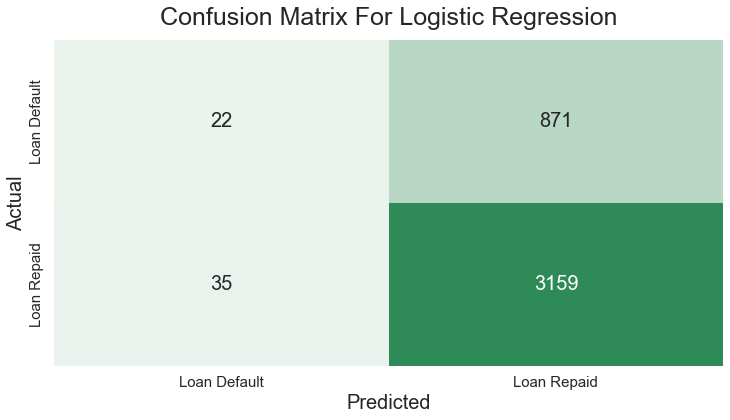

In [19]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [20]:
accuracy_score(y, y_pred)

0.7783215072180083

In [21]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

3159
871
35
22
0.7783215072180083


In [22]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    3194
0.0     893
Name: loan_status_bin, dtype: int64

0.781502324443357


In [23]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 0.1% better than Null Model or "random investment"
TP / (TP+FP)

0.7838709677419354

In [24]:
#What if we "balance" the weight class to avoid "imbalanced" nature...No Change! 

In [25]:
lr_balanced = LogisticRegression(class_weight='balanced')

In [26]:
steps_balanced = [('model', lr_balanced)]
pipeline_balanced = Pipeline(steps=steps)

In [27]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline_balanced, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.78361858 0.77506112 0.78457772 0.77723378 0.77111383]
0.7783210086397548


In [28]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred_balanced = cross_val_predict(pipeline_balanced, X, y, cv=cv, n_jobs=-1)
conf_mat_balanced = confusion_matrix(y, y_pred_balanced)
conf_mat_balanced

array([[  22,  871],
       [  35, 3159]])

In [29]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [30]:
y_pred_prob

array([[0.30459439, 0.69540561],
       [0.26309301, 0.73690699],
       [0.29205447, 0.70794553],
       ...,
       [0.20936136, 0.79063864],
       [0.293575  , 0.706425  ],
       [0.2199548 , 0.7800452 ]])

In [39]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.90).astype('float')
y_pred_success

array([0., 0., 0., ..., 0., 0., 0.])

In [40]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[ 853,   40],
       [2818,  376]])

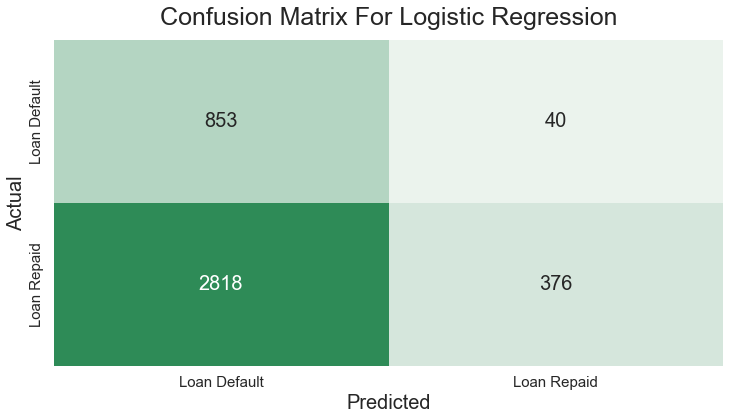

In [41]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [42]:
accuracy_score(y, y_pred_success)

0.30070956691950085

In [43]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

376
40
2818
853
0.30070956691950085


In [44]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.9038461538461539

In [37]:
thresh = []
PosPredVal = []

for i in range(0,100,1):
    y_pred_success = (y_pred_prob[:, 1] > (i/100)).astype('float')
    conf_mat = confusion_matrix(y, y_pred_success)
    TN, FP, FN, TP = conf_mat.ravel()
    thresh.append(i)
    PosPredVal.append((TP/(TP+FP)))

print(np.max(PosPredVal))
print(PosPredVal.index(np.max(PosPredVal)))

0.9166666666666666
96


In [38]:
PosPredVal

[0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.781502324443357,
 0.7816935878609887,
 0.7816935878609887,
 0.7816935878609887,
 0.7816935878609887,
 0.7816935878609887,
 0.7821612349914236,
 0.782000980872977,
 0.7823846908734053,
 0.7823312883435583,
 0.7825233186057928,
 0.7828009828009828,
 0.7831325301204819,
 0.7834112724587743,
 0.7834441980783444,
 0.7834567901234568,
 0.7835765520652981,
 0.78

In [30]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [31]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 